## Ensemble trees with each subject


In this analysis, we aim to build a model that predicts student grades, but instead of using data from all subjects, we focus on just one subject at a time. This allows us to study that subject in more detail and understand how well we can predict grades specifically for it. Altough we know that this will be just used for comparison as it would be computationally expensive to do this for each subject.

To do this, we start by loading the cleaned dataset. Then, we select only the data related to the subject we're interested in, such as "Fonaments d'enginyeria, Àlgebra" or etc. This helps us create a more focused and specialized model.

Next, we choose the most relevant features for prediction , things like the student's access grade, gender, and parents’ education. These features are used to train an ensemble model made of decision trees, which are known for being strong predictors.

Finally, we test how well the model works and use it to predict grades for the most recent academic year (2023/24). This approach gives us clear insights into each subject's predictability and helps compare performance across different models.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from DATASET import clean_df  # Imports the final merged & cleaned DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [16]:
# Now create the train and prediction split
df = clean_df.copy()

# Remove rows without a grade
df = df.dropna(subset=['nota_assignatura'])

# Split into training (all years except 2023/24) and prediction (2023/24)
df_train = df[df['curs_academic'] != '2023/24'].copy()
df_pred_target = df[df['curs_academic'] == '2023/24'].copy()

In [17]:
best_features = [
    'assignatura', 'codi_assignatura', 'curs_academic', 'discapacitat',
    'estudis_mare', 'estudis_pare', 'nota_d_acces', 'sexe',
    'taxa_exit', 'via_acces_estudi'
]


In [18]:
chosen_subject = 'Fonaments dels computadors' 

df_subject_train = df_train[df_train['assignatura'] == chosen_subject].copy()
df_subject_pred = df_subject_pred.dropna(subset=['nota_assignatura', 'predicted_nota_assignatura'])


X_train_subj = df_subject_train[best_features]
y_train_subj = df_subject_train['nota_assignatura']

X_pred_subj = df_subject_pred[best_features]

categorical_cols_subj = X_train_subj.select_dtypes(include='object').columns.tolist()

preprocessor_subj = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_subj)],
    remainder='passthrough'
)

ensemble_pipeline_subj = Pipeline([
    ('preprocessor', preprocessor_subj),
    ('regressor', VotingRegressor([
        ('rf', RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
        ('dt', DecisionTreeRegressor(max_depth=8, random_state=42))
    ]))
])


ensemble_pipeline_subj.fit(X_train_subj, y_train_subj)
df_subject_pred['predicted_nota_assignatura'] = ensemble_pipeline_subj.predict(X_pred_subj)


print(df_subject_pred[['assignatura', 'predicted_nota_assignatura']])


                      assignatura  predicted_nota_assignatura
24814  Fonaments dels computadors                    4.730509
24837  Fonaments dels computadors                    3.444154
24846  Fonaments dels computadors                    7.026371
24866  Fonaments dels computadors                    7.732169
24891  Fonaments dels computadors                    4.462390
...                           ...                         ...
32840  Fonaments dels computadors                    6.839248
32864  Fonaments dels computadors                    4.747572
32894  Fonaments dels computadors                    6.188308
32908  Fonaments dels computadors                    5.815240
32924  Fonaments dels computadors                    6.445131

[243 rows x 2 columns]


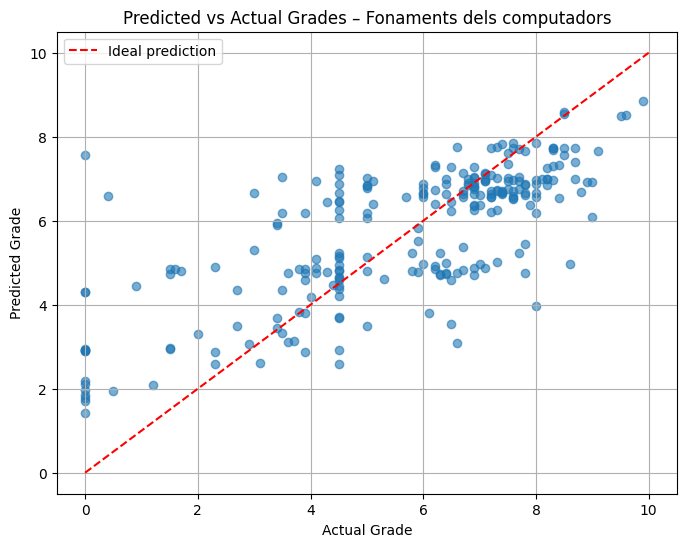

In [19]:
# Compare predicted and actual 
df_subject_pred = df_subject_pred.copy()
df_subject_pred = df_subject_pred.dropna(subset=['nota_assignatura', 'predicted_nota_assignatura'])

plt.figure(figsize=(8, 6))
plt.scatter(df_subject_pred['nota_assignatura'], df_subject_pred['predicted_nota_assignatura'], alpha=0.6)
plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='Ideal prediction')
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.title(f"Predicted vs Actual Grades – {chosen_subject}")
plt.legend()
plt.grid(True)
plt.show()

### How well is the model's performance just with 1 subject?

In [21]:
comparison_df = df_subject_pred[['nota_assignatura', 'predicted_nota_assignatura']].copy()
comparison_df.columns = ['Actual Grade', 'Predicted Grade']
comparison_df.head(20)  # Only 20



,Actual Grade,Predicted Grade
24814,6.3,4.730509
24837,3.4,3.444154
24846,7.5,7.026371
24866,8.3,7.732169
24891,4.4,4.462390
24907,7.9,6.369550
24921,3.7,3.144111
24943,4.5,4.437543
24982,4.5,4.800281
25013,7.2,6.555678


In [25]:
#R² Score (Coefficient of Determination)
r2 = r2_score(df_subject_pred['nota_assignatura'], df_subject_pred['predicted_nota_assignatura'])
print(f"R² Score: {r2:.3f}")

#RMSE (Root Mean Squared Error)
mse = mean_squared_error(df_subject_pred['nota_assignatura'], df_subject_pred['predicted_nota_assignatura'])
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.3f}")

#MAE (Mean Absolute Error)
mae = mean_absolute_error(df_subject_pred['nota_assignatura'], df_subject_pred['predicted_nota_assignatura'])
print(f"MAE: {mae:.3f}")

R² Score: 0.540
RMSE: 1.632
MAE: 1.217


Your model shows an **R² score of 0.540**, meaning it explains about 54% of the variation in student grades. This is a decent result for educational data, which often has unpredictable factors like motivation or personal issues.

The **RMSE of 1.63** and **MAE of 1.22** suggest the model’s predictions are usually within about 1–1.5 points of the actual grade. That’s fairly accurate for general trends, but not precise enough for individual grading decisions.

Overall, the model is **useful and promising**, but there’s still room to improve. Adding more detailed features or fine-tuning the model could help increase accuracy.


---
Regarding our first hypothesis (that a model trained on a single subject performs better than one trained on all subjects) the results clearly support it. When focusing on just one subject, the model's R² score improved from 0.37 to 0.54, indicating that it can explain more of the variance in student grades. Additionally, both the MAE and RMSE values were lower, meaning the predictions were closer to the actual grades.

This improvement makes sense: combining all subjects introduces a lot of variability due to differences in content, difficulty, and student backgrounds. That extra noise can make learning patterns harder. In contrast, modeling a single subject allows the model to focus on more consistent patterns, leading to better performance. Overall, this confirms that subject-specific models are more effective for predicting student grades.

---